# Predicting Food Delivery Time 

I have been contracted by Cluck Cluck Go, a new food delivery service, to enhance the 
accuracy of food delivery time estimations. This notebook analyzes food delivery times using machine learning to predict delivery times based on various factors like distance, weather, traffic, and more.

### Importing Libraries & Data

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# Load dataset
df = pd.read_csv('food_delivery_times.csv')

### Exploratory Data Analysis (EDA)

In [ ]:
# Data shape
print(f'Dataset shape: {df.shape}')

Dataset shape: (1000, 9)


In [ ]:
# Display dataset information
print(f'\nDataset info:\n{df.info()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB

Dataset info:
None


In [ ]:
# Check for missing values
print(f'\nMissing values:\n{df.isnull().sum()}')


Missing values:
Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64


### Data Cleaning

In [ ]:
# Drop rows with any missing values
df_clean = df.dropna()
print(f'Dataset shape after dropping nulls: {df_clean.shape}')
print(f'Rows removed: {df.shape[0] - df_clean.shape[0]} ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.1f}%)')

Dataset shape after dropping nulls: (883, 9)
Rows removed: 117 (11.7%)


In [ ]:
# Remove Outliers
def remove_outliers_iqr(df, cols):
    df_clean = df.copy()
    summary = {}
    for col in cols:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
        outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)].index
        summary[col] = len(outliers)
        df_clean.drop(outliers, inplace=True)
    df_clean.reset_index(drop=True, inplace=True)
    return df_clean, summary

num_cols = ['Distance_km', 'Preparation_Time_min', 'Delivery_Time_min']
df_clean, outlier_summary = remove_outliers_iqr(df, num_cols)
print(f'Rows removed due to outliers: {sum(outlier_summary.values())}')

# Apply outlier removal to numerical columns
num_cols = ['Distance_km', 'Preparation_Time_min', 'Delivery_Time_min']
df_clean, outlier_summary = remove_outliers_iqr(df_clean, num_cols)
print(f'Rows removed due to outliers: {sum(outlier_summary.values())}')
print(f'Final dataset shape: {df_clean.shape}')

Rows removed due to outliers: 6
Rows removed due to outliers: 0
Final dataset shape: (994, 9)


In [8]:
# Save cleaned dataset
df_clean.to_csv('food_delivery_times_cleaned.csv', index=False)

### Feature Engineering

In [ ]:
# Encode categorical variables
categorical_features = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
df_encoded = df_clean.copy()
label_encoders = {}

for col in categorical_features:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f'Encoded {col}: {list(le.classes_)}')

# Define features and target variable
features = ['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 
            'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']

# Select available features from the dataset
X = df_encoded[[c for c in features if c in df_encoded.columns]]
y = df_encoded['Delivery_Time_min']

print(f'Features used: {list(X.columns)}')
print(f'Feature matrix shape: {X.shape}')
print(f'Target variable shape: {y.shape}')

Encoded Weather: ['Clear', 'Foggy', 'Rainy', 'Snowy', 'Windy', 'nan']
Encoded Traffic_Level: ['High', 'Low', 'Medium', 'nan']
Encoded Time_of_Day: ['Afternoon', 'Evening', 'Morning', 'Night', 'nan']
Encoded Vehicle_Type: ['Bike', 'Car', 'Scooter']
Features used: ['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']
Feature matrix shape: (994, 7)
Target variable shape: (994,)


### Model Training

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

# Initialize and train Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=2, 
    random_state=42
)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

print('Training completed!')

Training set shape: (795, 7)
Test set shape: (199, 7)
Training completed!


### Model Evaluation

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Model Performance Metrics:')
print(f'MAE (Mean Absolute Error): {mae:.2f} minutes')
print(f'RMSE (Root Mean Square Error): {rmse:.2f} minutes') 
print(f'R² (Coefficient of Determination): {r2:.4f}')

Model Performance Metrics:
MAE (Mean Absolute Error): 6.31 minutes
RMSE (Root Mean Square Error): 9.40 minutes
R² (Coefficient of Determination): 0.8218


In [ ]:
# Analyze feature importance
feat_imp = pd.DataFrame({
    'Feature': X.columns, 
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nFeature Importance Rankings:')
print(feat_imp)


Feature Importance Rankings:
                  Feature  Importance
0             Distance_km    0.723163
5    Preparation_Time_min    0.149805
2           Traffic_Level    0.035910
6  Courier_Experience_yrs    0.035321
1                 Weather    0.029526
3             Time_of_Day    0.014042
4            Vehicle_Type    0.012234


### Visualizations

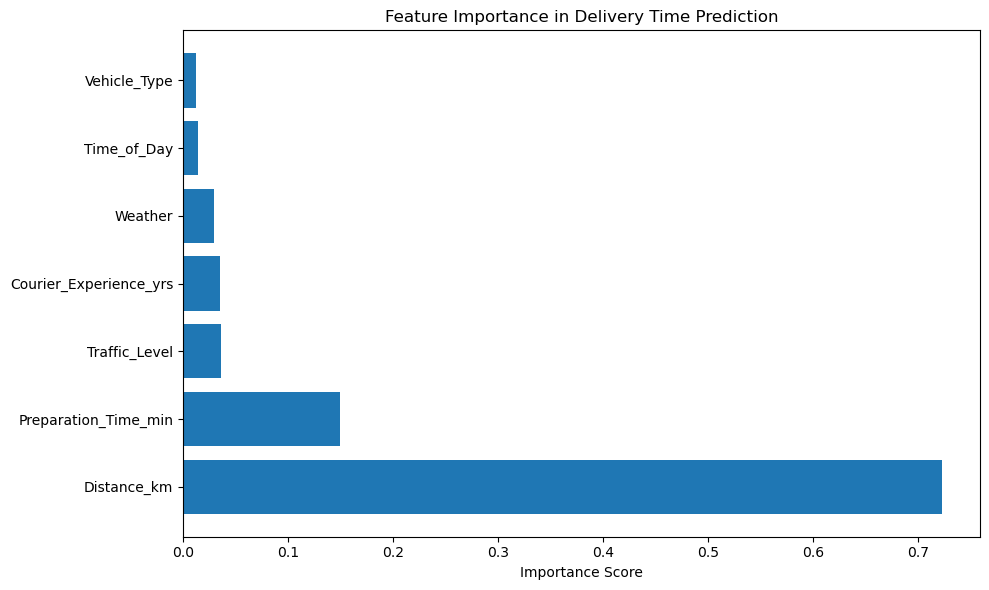

In [13]:
# Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.title('Feature Importance in Delivery Time Prediction')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

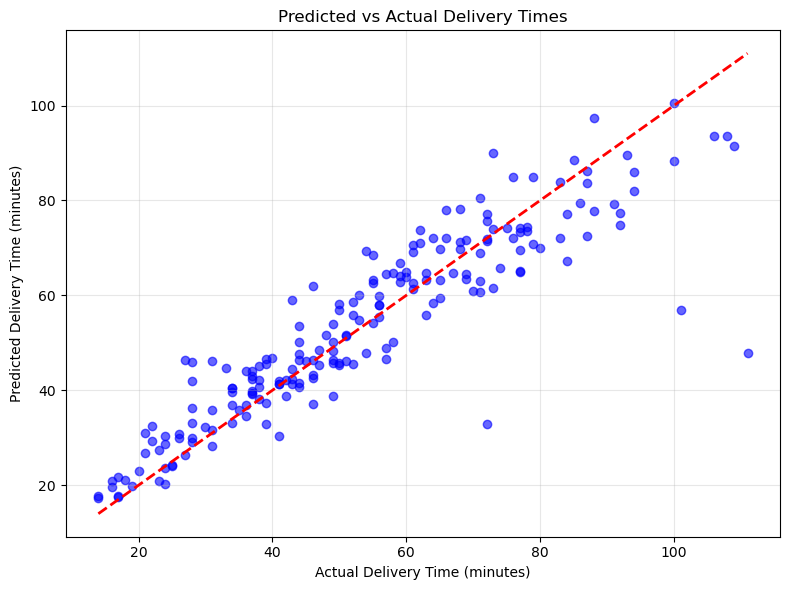

In [14]:
# Prediction vs Actual Plot Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Delivery Time (minutes)')
plt.ylabel('Predicted Delivery Time (minutes)')
plt.title('Predicted vs Actual Delivery Times')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predicted_vs_actual.png')
plt.show()

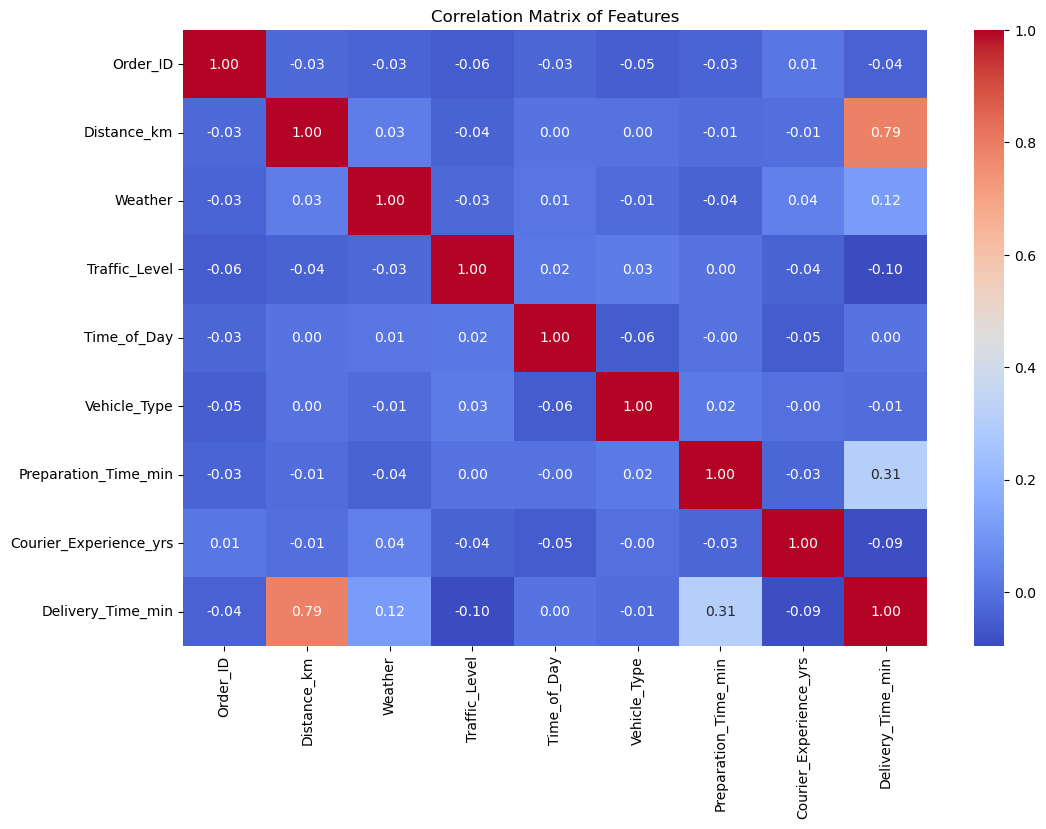

In [15]:
# Compute the correlation matrix using the encoded dataframe
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Features')
plt.savefig('correlation_matrix.png')
plt.show()